# Example of how to run a VQE for (2+1)D QED

In [1]:
import qiskit

In [2]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
from itertools import permutations
from scipy.sparse.linalg import eigsh

In [3]:
sys.path.append("../") # go to parent dir
from qclatticeh.hamiltonian.Hamiltonian_QED_sym import HamiltonianQED_sym
from qclatticeh.hamiltonian.Hamiltonian_QED_oprt import HamiltonianQED_oprt
from qclatticeh.lattice.HC_Lattice import HCLattice

### Start with the Hamiltonian

In [18]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
n_flavors = 1#how many flavors of particles

#Hamiltonian parameters:
g=0.5
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli=False
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [19]:
latt = HCLattice(n_sites,pbc=pbc,n_flavors=n_flavors)

In [20]:
# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'n_flavors': n_flavors,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': None,
    'e_op_out_plus': e_op_out_plus
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=True)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)

Alpha angle α=2 π/2L+1
HamiltonianQED_sym: Initializing...
>> Gauss law system of equations (symbolic + latex):
static charges: None


Eq(-E_00x - E_00y - q_00, 0)

Eq(E_00y - E_01x - q_01, 0)

Eq(E_00x - E_10y - q_10, 0)

Eq(E_01x + E_10y - q_11, 0)

Eq(q_00 + q_01 + q_10 + q_11, 0)

- E_{00x} - E_{00y} - q_{00} &= 0 \\ \nonumber
E_{00y} - E_{01x} - q_{01} &= 0 \\ \nonumber
E_{00x} - E_{10y} - q_{10} &= 0 \\ \nonumber
E_{01x} + E_{10y} - q_{11} &= 0 \\ \nonumber
q_{00} + q_{01} + q_{10} + q_{11} &= 0 

> Gauss law equations solved
> e_op_free and u_op_free built
>> Hamiltonian (symbolic + latex):


Eq(H_E, g**2*(E_10y**2 + (-E_10y + q_11)**2 + (E_10y + q_10)**2 + (-E_10y + q_01 + q_11)**2)/2)

H_{E} = \frac{g^{2} \left(E_{10y}^{2} + \left(- E_{10y} + q_{11}\right)^{2} + \left(E_{10y} + q_{10}\right)^{2} + \left(- E_{10y} + q_{01} + q_{11}\right)^{2}\right)}{2}


Eq(H_B, -(U_10y + h.c.)/(2*g**2))

H_{B} = - \frac{U_{10y} + h.c.}{2 g^{2}}


Eq(H_K, Omega*(0.5*I*(-h.c.(x) + Dagger(Phi_1)*Phi_2 + Dagger(Phi_4)*Phi_3) - 0.5*(h.c.(y) + Dagger(Phi_1)*Phi_4 - Dagger(Phi_2)*Dagger(U_10y)*Phi_3)))

H_{K} = \Omega \left(0.5 i \left(- h.c.(x) + \Phi_{1}^{\dagger} \Phi_{2} + \Phi_{4}^{\dagger} \Phi_{3}\right) - 0.5 \left(h.c.(y) + \Phi_{1}^{\dagger} \Phi_{4} - \Phi_{2}^{\dagger} U_{10y}^{\dagger} \Phi_{3}\right)\right)


Eq(H_m, m*(Dagger(Phi_1)*Phi_1 - Dagger(Phi_2)*Phi_2 + Dagger(Phi_3)*Phi_3 - Dagger(Phi_4)*Phi_4))

H_{m} = m \left(\Phi_{1}^{\dagger} \Phi_{1} - \Phi_{2}^{\dagger} \Phi_{2} + \Phi_{3}^{\dagger} \Phi_{3} - \Phi_{4}^{\dagger} \Phi_{4}\right)
>> Gauss law applied and Hamiltonian built.  Execution time: 0.031600236892700195 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
qubit order |qn...q2q1q0>: [q_01, q_11, q_10, q_00, U_10y]
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 2.447761058807373 seconds
Hamiltonian suppr fermions...
Hamiltonian suppr fermions done
>> Suppression term built.  Execution time: 0.0022628307342529297 seconds


### Obtain a specific Hamiltonian for a certain set of values

In [37]:
H_ed = class_H_oprt.get_hamiltonian(g_var=5, m_var=2, chem_pot=0, fact_e_op=fact_e_op, fact_b_op=fact_b_op, lambd=1000)
H_vqe = class_H_oprt.get_hamiltonian(g_var=5, m_var=2, chem_pot=0, fact_e_op=fact_e_op, fact_b_op=fact_b_op, lambd=0)

Note, the lambd parameter could have been set the same, yet it is not needed and penalty terms can be disadvantegous for VQE.

In [38]:
eigvals, eigvecs = eigsh(H_ed.to_matrix(), k=1, which='SA', tol=threshold)

## Get the correct ansatz circuit

In [39]:
from qclatticeh.circuits.Ansaetze import Ansatz

In [40]:
ngauge = class_H_oprt.len_e_op

n_fermions = np.prod(latt.n_sites)

nlayersgauge = 1
nlayersferm = 5
entanglement = 'full'
rzlayer = True
puregauge = False
use_for_nft = True

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))


ansatz_class = Ansatz(l,ngauge,nfermions=n_fermions,gauge_list= class_H_oprt.uop_list,ferm_list=class_H_oprt.qop_list, n_flavors=1, use_for_nft=use_for_nft)

In [41]:
qc_tot2,first_layer_par = ansatz_class.gauge_fermion_circuit(entanglement=entanglement,rzlayer=rzlayer,nlayersgauge=nlayersgauge,nlayersferm=nlayersferm)

### Write a simple VQE scheme

In [42]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [43]:
backend = AerSimulator()

Now we can transpile for this backend

In [44]:
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)

ansatz_isa = pm.run(qc_tot2)
H_isa = H_vqe.apply_layout(ansatz_isa.layout)

In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [47]:
x0 = 2 * np.pi * np.random.random(ansatz_isa.num_parameters)

In [48]:
from scipy.optimize import minimize

In [49]:
estimator = EstimatorV2(mode=backend)
estimator.options.default_shots = 10000

res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, H_isa, estimator),
    method="cobyla",
)

Iters. done: 1 [Current cost: 48.17025100000001]
Iters. done: 2 [Current cost: 47.6883605]
Iters. done: 3 [Current cost: 49.671842500000004]
Iters. done: 4 [Current cost: 39.6309815]
Iters. done: 5 [Current cost: 39.612699000000006]
Iters. done: 6 [Current cost: 35.626649500000006]
Iters. done: 7 [Current cost: 41.601816500000005]
Iters. done: 8 [Current cost: 36.7090905]
Iters. done: 9 [Current cost: 43.08755100000002]
Iters. done: 10 [Current cost: 42.7492915]
Iters. done: 11 [Current cost: 36.74856849999999]
Iters. done: 12 [Current cost: 40.33199899999998]
Iters. done: 13 [Current cost: 41.544608499999995]
Iters. done: 14 [Current cost: 43.054501999999985]
Iters. done: 15 [Current cost: 36.139450499999995]
Iters. done: 16 [Current cost: 34.19947]
Iters. done: 17 [Current cost: 33.09413450000002]
Iters. done: 18 [Current cost: 34.74378749999999]
Iters. done: 19 [Current cost: 32.882849]
Iters. done: 20 [Current cost: 33.225683999999994]
Iters. done: 21 [Current cost: 33.079078]
Iter

In [50]:
print("ED result: ",eigvals[0])
print("VQE result: ",res.fun)

ED result:  -4.060456195262275
VQE result:  -3.778978500000002


We can also take a look at the convergence. Note, this is not optimzed in terms of performance, but only acts as an example of the functionality. With optimization, fidelities of close to 100% can be reached.

In [51]:
import matplotlib.pyplot as plt

Text(0, 0.5, '$\\langle E\\rangle$')

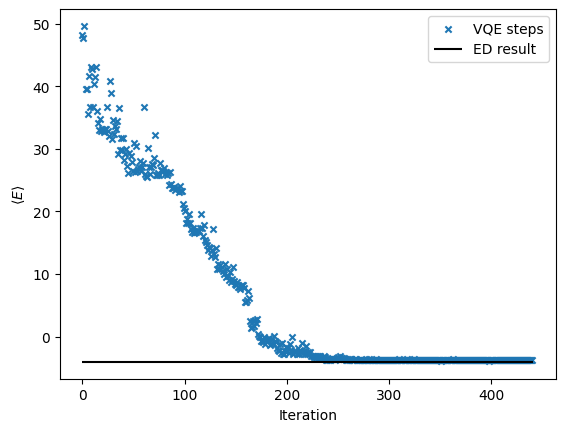

In [ ]:
plt.figure()
plt.scatter(np.arange(len(cost_history_dict["cost_history"])),cost_history_dict["cost_history"], s=20, marker="x", label="VQE steps")
plt.hlines(eigvals[0],0,len(cost_history_dict["cost_history"]), color="black", label="ED result")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel(r"$\langle E\rangle$")

Text(0, 0.5, '$\\left|\\frac{\\langle E_i\\rangle - E_\\text{correct}}{E_\\text{correct}}\\right|$')

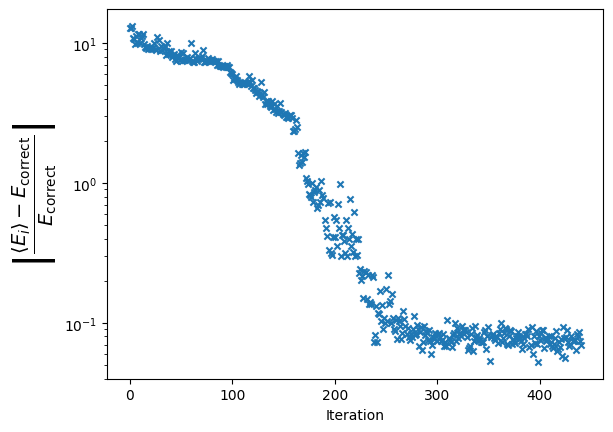

In [76]:
plt.figure()
plt.scatter(np.arange(len(cost_history_dict["cost_history"])),np.abs((cost_history_dict["cost_history"]-eigvals[0])/eigvals[0]), s=20, marker="x")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel(r"$\left|\frac{\langle E_i\rangle - E_\text{correct}}{E_\text{correct}}\right|$", fontsize=20)